In [1]:
import os
import random

import cv2 as cv
from PIL import Image, ImageDraw

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

2024-07-26 09:57:54.773249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 09:57:54.773361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 09:57:54.900396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGES_DIR = "/kaggle/input/airbus-ship-detection/train_v2"
MASKS_CSV_DIR = "/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv"

In [3]:
# read the csv file
df = pd.read_csv(MASKS_CSV_DIR)

In [4]:
df.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [6]:
# number of unique images in the dataset
df.nunique()

ImageId          192556
EncodedPixels     81722
dtype: int64

In [7]:
# merged the encoded pixels of the same image ids into a single row.
df = df.groupby("ImageId")["EncodedPixels"].apply(lambda x: ' '.join(x.dropna())).reset_index()
df["EncodedPixels"] = df["EncodedPixels"].replace("", np.nan)

In [8]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192556 entries, 0 to 192555
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        192556 non-null  object
 1   EncodedPixels  42556 non-null   object
dtypes: object(2)
memory usage: 2.9+ MB


In [9]:
df.isna().sum() # Images doesn't contains any instances of ships.

ImageId               0
EncodedPixels    150000
dtype: int64

In [10]:
(df.isna().sum()/len(df))*100 # Percentages of images doesn't contains any instances.

ImageId           0.000000
EncodedPixels    77.899416
dtype: float64

<font size="4">
We observed that the dataset contains of a total of 231,723 rows. Within this dataset, there are 192,556 unique images. Among these images, their are 81,723 instances of ships. Some of the images contain multiple instances of ships, while others do not contain any ships at all. Around 150,000 images doen't contain any instances of ships which is around 65% of the images in the dataset. This will create unbalanced dataset. To address this imbalance, we need to consider removing some of the images that do not contains ships. Depending on the size of dataset, it's recommended to include only 1-10% of background images (those without ships) in the dataset. Given the large size of the our dataset, I plan to include only 1% of the background image to the dataset.
</font>

In [11]:
# select images that doesn't have any instances.
background_imgs = df[df.isna().any(axis=1)]

# Randomly select rows to drop
droped_rows = background_imgs.sample(n=int(0.99 * len(background_imgs))).index 

# drop the selected rows form the dataframe
df = df.drop(droped_rows) # drop 99% of images that don't contains any instances.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44056 entries, 2 to 192550
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        44056 non-null  object
 1   EncodedPixels  42556 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [13]:
def wrangle():
    # read the csv file
    df = pd.read_csv(MASKS_CSV_DIR)
    
    # merged the encoded pixels of the same image ids into a single row.
    df = df.groupby("ImageId")["EncodedPixels"].apply(lambda x: ' '.join(x.dropna())).reset_index()
    df["EncodedPixels"] = df["EncodedPixels"].replace("", np.nan)
    
    # select images that doesn't have any instances.
    background_imgs = df[df.isna().any(axis=1)]

    # Randomly select rows to drop
    droped_rows = background_imgs.sample(n=int(0.99 * len(background_imgs))).index # drop 99% of images that don't contains any instances.

    # drop the selected rows form the dataframe
    df = df.drop(droped_rows)
    
    return df

In [14]:
df = wrangle()

In [15]:
df = df.sample(n=10000)

In [16]:
def rle2mask(mask_rle, shape):
    """
    Converts a run-lenght-encoder (RLE) string to a binary mask.

    Args:
        mask_rle: Run-length encoded string
        shape: Tuple (height, width) of the output mask.

    Returns:
        binary mask of the given shape.
    """

    # split the RLE string and convert to integres.
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]

    # Adjust starts to be zero-indexed
    starts -= 1
    # Compute the ending positions of the runs
    ends = starts + lengths

    # Initialize the mask with zeros
    img = np.zeros(shape[0]*shape[1], dtype=np.float32)

    # Set the pixels within the runs to 1
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    # Reshape the flat array to the specified shape
    return img.reshape((shape[1], shape[0])).T

In [17]:
def overlay_mask1(image, mask, overlay_color=(0, 0, 255), alpha=0.5):
    """
    Overlays a segmentation mask on a real image with a solid transparent color on segmented areas.

    Args:
        image (np.array): The real image in BGR format.
        mask (np.array):  The mask image
        overlay_color (tuple): solid color for overlay.
        transparency: value between 0 and 1 for overlay color opacity.

    Returns:
        (np.array): the overlaid image.
    """

    # convert mask to same number of channels as actual image.
#     mask = cv.cvtColor(mask, cv.COLOR_GRAY2BGR)

    # Create a color image the same size as the original image
    colored_mask = np.zeros_like(image, dtype=np.uint8)
    colored_mask[:] = overlay_color
    
    # Apply the mask to the colored mask
    mask = mask.astype(bool)
    colored_mask = cv.bitwise_and(colored_mask, colored_mask, mask=mask.astype(np.uint8))
    
    # Blend the original image with the colored mask
    overlay = cv.addWeighted(image, 1.0, colored_mask, alpha, 0)
    
    return overlay

In [18]:
SEED = 42
BATCH = 8
LEARNING_RATE = 0.0001
NUM_CLASSES = 1
IMG_SHAPE = (512, 512)
EPOCHS=20

## Split the Dataset

In [19]:
# split into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [20]:
print(f"Total Training size: {len(train_df)}")
print(f"Total Validation size: {len(val_df)}")

Total Training size: 8000
Total Validation size: 2000


## Preprocess the dataset

In [21]:
def generator(dataframe, images_dir, img_shape):
    def _generator():            
        for i, (_, row) in enumerate(dataframe.iterrows()):
            image_path = f"{images_dir}/{row.ImageId}"
            # Read the image
            image = cv.imread(image_path)
            
            # Check if there are encoded pixels for the mask
            if not pd.isna(row.EncodedPixels):
                # Convert encoded mask to a binary mask
                mask = rle2mask(row.EncodedPixels, image.shape[:2])
            else:
                # If no encoded pixels, create an empty mask
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
            
            # Resize the image
            image = cv.resize(image, img_shape)
            
            # Resize the mask
            mask = cv.resize(mask, img_shape, interpolation=cv.INTER_NEAREST)
            mask = np.expand_dims(mask, axis=-1)

            yield image, mask
    return _generator

## Visualize the images and masks

In [22]:
# select sample dataset for visualization purpose
data_generator = generator(df.sample(n=4), IMAGES_DIR, IMG_SHAPE)

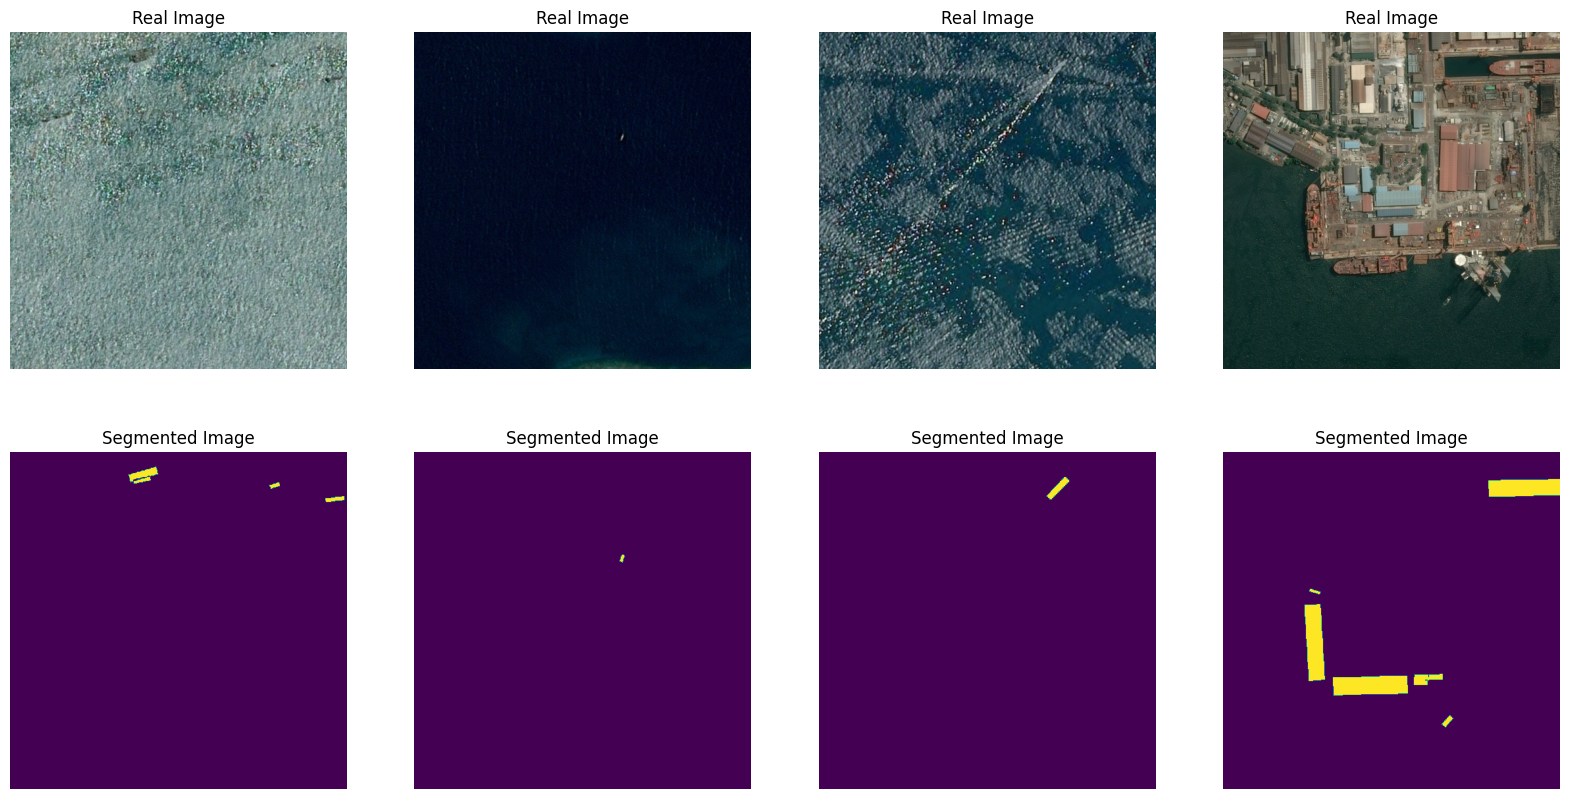

In [23]:
plt.figure(figsize = (20,10))
for i, (image, mask) in enumerate(data_generator()):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.subplot(2, 4, i+1)
    plt.imshow(tf.cast(image, dtype=tf.float32)/255.)
    plt.title(f'Real Image')
    plt.axis('off')
    plt.subplot(2, 4, i+5)
    plt.imshow(mask)
    plt.title(f'Segmented Image')
    plt.axis('off')

In [24]:
def create_tf_dataset(dataframe, images_dir, img_shape, batch):
    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_generator(
        generator(dataframe, images_dir, img_shape),
        output_signature=(
            tf.TensorSpec(shape=(img_shape[0], img_shape[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(img_shape[0], img_shape[1], 1), dtype=tf.float32)
        )
    )

    # Batch the dataset and prefetch for better performance
    dataset = dataset.batch(batch).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [25]:
# create tensorflow dataset
train_dataset = create_tf_dataset(train_df, IMAGES_DIR, IMG_SHAPE, BATCH)
val_dataset = create_tf_dataset(val_df, IMAGES_DIR, IMG_SHAPE, BATCH)

## Build the Model

In [26]:
def conv_block(inputs, num_filters):
    # implementing the first conv block.
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding='same', kernel_initializer="he_normal")(inputs)
    batch_norm = tf.keras.layers.BatchNormalization()(conv)
    act = tf.keras.layers.Activation('relu')(batch_norm)

    # implementing the second conv block.
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(act)
    batch_norm = tf.keras.layers.BatchNormalization()(conv)
    act = tf.keras.layers.Activation("relu")(batch_norm)

    return act

In [27]:
def encoder_block(inputs, num_filters):    
    skip = conv_block(inputs, num_filters) # convolutional block
    max_pool = tf.keras.layers.MaxPooling2D((2,2))(inputs) # pooling  block

    return skip, max_pool

In [28]:
def decoder_block(inputs, skip, num_filters):
    # upsampling and concatenating the input features.
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2,2), padding='same')(inputs)  # upsampling block
    connect_skip = tf.keras.layers.concatenate([upsample, skip])
    out = conv_block(connect_skip, num_filters)

    return out

In [29]:
def build_unet(n_classes: int, height: int, width: int, channel: int):

    inputs = tf.keras.layers.Input((height, width, channel))

    # Defining the encoder (down sampler)
    skip1, max_pool1 = encoder_block(inputs, num_filters=64)
    skip2, max_pool2 = encoder_block(max_pool1, num_filters=128)
    skip3, max_pool3 = encoder_block(max_pool2, num_filters=256)
    skip4, max_pool4 = encoder_block(max_pool3, num_filters=512)
    
    # Defining the bottleneck
    bridge = conv_block(max_pool4, num_filters=1024)

    # Defining the decoder (up sampler)
    u4 = decoder_block(bridge, skip4, num_filters=512)
    u3 = decoder_block(u4, skip3, num_filters=256)
    u2 = decoder_block(u3, skip2, num_filters=128)
    u1 = decoder_block(u2, skip1, num_filters=64)

    # output function
    outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='sigmoid')(u1)
    
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs], name="Unet")

    return model

## Metrics

In [30]:
def dice_coeff(y_true, y_pred, smooth = 1e-6):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred, axis=-1)
    union = tf.keras.backend.sum(y_true, axis=-1) + tf.keras.backend.sum(y_pred, axis=-1)
    dice_coeff = (2 * intersection + smooth) / (union + smooth)

    return dice_coeff

In [31]:
def dice_coeff_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

## Compile and fit the Model

In [32]:
def compile_model(model, train_data, val_data, epochs: int, learning_rate: float):
    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-06),
        loss = [dice_coeff_loss],
        metrics=[dice_coeff])

    # define early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=5,
                                                 verbose=1,
                                                 mode='min',
                                                 restore_best_weights=True)


        
    # save checkpoints
    checkpoint_dir = './models'
    checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.keras')
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir, exist_ok=True)
    
    # define model checkpoint callback
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor='val_loss',
                                                    save_best_only=True,
                                                    save_freq='epoch')
    
    # define the learning rate reducer
#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
#                                                      factor=0.1,
#                                                      patience=5,
#                                                      verbose=1,
#                                                      mode='min',
#                                                      min_lr=1e-5)

    # fit the model
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        callbacks=[early_stopping, checkpoint])
    
    return history


In [33]:
# build the model
model = build_unet(n_classes=NUM_CLASSES, height=IMG_SHAPE[0], width=IMG_SHAPE[1], channel=3)

In [34]:
# model summary
model.summary()

Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64, 3) │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32, 3) │          0 │ max_pooling2d_2[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     28,672 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      4,096 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     14,336 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      2,048 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  9,438,208 │ activation_8[0][… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      4,096 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │  2,359,808 │ activation_6[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      2,048 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  2,097,664 │ activation_9[0][

 Total params: 24,840,257 (94.76 MB)

 Trainable params: 24,828,481 (94.71 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [35]:
output_dir = os.makedirs('./outputs', exist_ok=True)
file_path = os.path.join('./outputs', 'model_summary.png')
tf.keras.utils.plot_model(model, to_file=file_path, show_shapes=True)

In [36]:
# compile and fit the model
history = compile_model(model=model, train_data=train_dataset, val_data=val_dataset, epochs=EPOCHS, learning_rate=LEARNING_RATE)

Epoch 1/20


2024-07-26 09:59:28.021297: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.37599, expected 3.38235
2024-07-26 09:59:28.021366: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.67496, expected 4.68133
2024-07-26 09:59:28.021375: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.02051, expected 5.02687
2024-07-26 09:59:28.021383: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.32685, expected 4.33322
2024-07-26 09:59:28.021391: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.93495, expected 3.94132
2024-07-26 09:59:28.021399: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.2295, expected 4.23587
2024-07-26 09:59:28.021406: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.39933, expected 3.40569
2024-07-26 09:59:28.021414: E external/local_xla/xla/ser

   1000/Unknown 813s 696ms/step - dice_coeff: 0.1341 - loss: 0.8659

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 875s 758ms/step - dice_coeff: 0.1342 - loss: 0.8658 - val_dice_coeff: 0.4264 - val_loss: 0.5736
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 758s 758ms/step - dice_coeff: 0.4855 - loss: 0.5145 - val_dice_coeff: 0.5716 - val_loss: 0.4284
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 760s 760ms/step - dice_coeff: 0.5875 - loss: 0.4125 - val_dice_coeff: 0.6063 - val_loss: 0.3937
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 760s 760ms/step - dice_coeff: 0.6276 - loss: 0.3724 - val_dice_coeff: 0.6180 - val_loss: 0.3820
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 759s 759ms/step - dice_coeff: 0.6486 - loss: 0.3514 - val_dice_coeff: 0.6375 - val_loss: 0.3625
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 759s 758ms/step - dice_coeff: 0.6661 - loss: 0.3339 - val_dice_coeff: 0.6388 - val_loss: 0.3612
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 759s 759ms/step - dice_coeff: 0.6876 - loss: 0.3124 - val_dice_coeff: 0.6412 - val_loss: 0.3588
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 759

## Plot the training and validation history

In [37]:
def plot_history(history, eval_type, y=None):
    plt.figure(figsize=(5, 4))
    plt.plot(history.history[eval_type], label=f"Training {eval_type}")
    plt.plot(history.history[f'val_{eval_type}'], label=f"Validation {eval_type}")
    plt.xlabel("Epoch")
    plt.ylabel(eval_type)
    plt.title(f"Training vs. Validation {eval_type.capitalize()}")
    plt.grid(True)
    plt.legend(loc='upper left')

    plot_filename = f"training_validation_{eval_type}.png"
    plt.savefig(plot_filename)

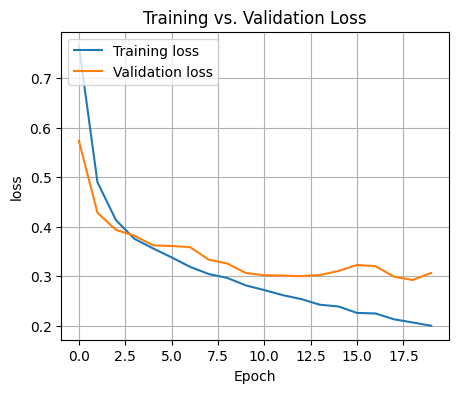

In [38]:
plot_history(history, eval_type="loss")

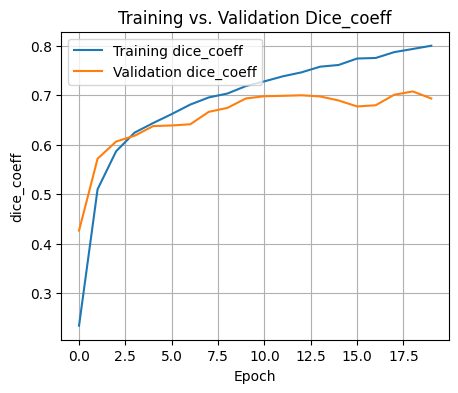

In [39]:
plot_history(history, eval_type="dice_coeff")

## Save the model

In [40]:
from datetime import datetime

def save_model(model, output_dir='./models'):
    """Saves the trained model."""
    os.makedirs(output_dir, exist_ok=True)
    
    timestamp = datetime.now()
    formatted_timestamp = timestamp.strftime("%Y%m%d%H%M")
    file_path = os.path.join(output_dir, f'unet_{formatted_timestamp}.h5')
    model.save(file_path)

    return file_path

In [41]:
save_model(model)

'./models/unet_202407261414.h5'